In [33]:
import pandas as pd
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

from add_indicators import bollinger_bands, rsi, macd, add_all_indicators

import numpy as np
from sklearn.inspection import permutation_importance

In [2]:
def show_all():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

def add_change(df):
    df['% Change'] = df['Close'].diff()
    df['% Change'] = df['% Change']/df['Close']
    df['% Change'] = df['% Change'].shift(periods=-1)
    
def add_volume(df):
    df['% Volume'] = df['Volume'].diff()
    df['% Volume'] = df['% Volume']/df['Volume']
    #df['% Volume'] = df['% Volume'].shift(periods=-1)

def preprocess(df):
    add_change(df)
    add_volume(df)
    add_all_indicators(df)
    return df.dropna()

def create_model(model, train_X, train_y):
    model.fit(train_X, train_y)
    return model

def run_predictions(name, model, val_X, val_y):
    model_predictions = model.predict(val_X)
    mae = mean_absolute_error(val_y, model_predictions)
    score = r2_score(val_y, model_predictions)
    return name, mae, score

def plot(start, end, df):
    plt.plot(df['% Change'].iloc[start:end], label='% Change')
    plt.plot(df['rfr'].iloc[start:end], label='rfr')
    plt.plot(df['xgb'].iloc[start:end], label='xgb')
    plt.title('Results')
    plt.legend()
    plt.show()
    
def show_results(results):
    for r in results:
        df[r[0]] = r[1].predict(df[features])
        print('Model: ', r[0])
        print('% MAE: ', r[2])
        print('Score: ', r[3])
        print()

In [53]:
ticker = yf.Ticker("spy")
df = ticker.history(period="1y", interval="1d")

df = preprocess(df)
'''
features = ['Close', '% Volume',
            'bb_bbh', 'bb_bbl', 'bb_avg', 'bb_bbh_ind', 'bb_bbl_ind',
            'bb_pband', 'bb_wband', 'rsi', 'macd', 'macd_diff', 'macd_signal',
            'don_h', 'don_l', 'don_m', 'don_p', 'don_w',
            'ema_9', 'sma_5', 'sma_10', 'sma_15', 'sma_30', 'sma_50']
'''
features = ['Close', '% Volume',
            'bb_bbh', 'bb_bbl', 'bb_avg', 'bb_bbh_ind', 'bb_bbl_ind',
            'bb_pband', 'bb_wband', 'rsi', 'macd', 'macd_diff', 'macd_signal',
            'don_h', 'don_l', 'don_m', 'don_p', 'don_w',
            'ema_9', 'sma_5', 'sma_10', 'sma_15', 'sma_30', 'sma_50']

X = df[features].copy()
y = df['% Change'].copy()

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

<BarContainer object of 24 artists>

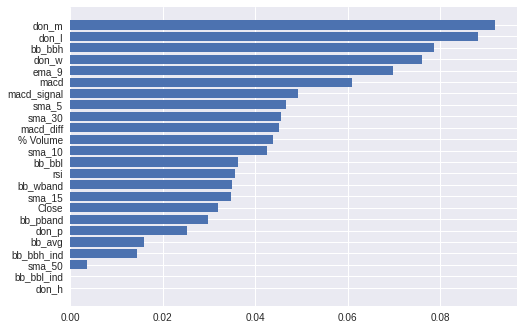

In [54]:
from matplotlib import pyplot as plot

model = XGBRegressor(objective='reg:squarederror')
model.fit(train_X, train_y)

sorted_index = model.feature_importances_.argsort()

plt.barh(np.array(features)[sorted_index], model.feature_importances_[sorted_index])

Text(0.5, 0, 'Permutation Importance')

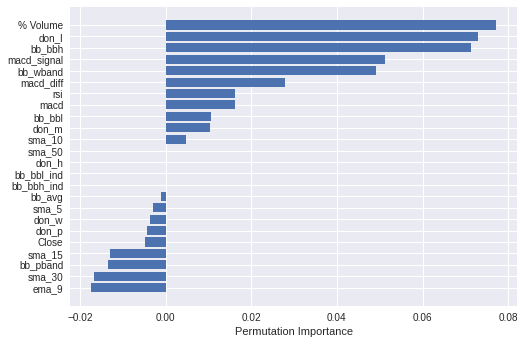

In [55]:
perm_importance = permutation_importance(model, val_X, val_y)
sorted_index = perm_importance.importances_mean.argsort()
plt.barh(np.array(features)[sorted_index], perm_importance.importances_mean[sorted_index])
plt.xlabel("Permutation Importance")

In [56]:
import seaborn as sns

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
#correlation_heatmap(train_X[np.array(features)[sorted_index]])

In [57]:
#https://machinelearningmastery.com/rfe-feature-selection-in-python/

# Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

rfe = RFE(estimator = XGBRegressor(), n_features_to_select=5)
model = XGBRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

MAE: -0.010 (0.002)
Column: 0, Selected False, Rank: 17.000
Column: 1, Selected False, Rank: 7.000
Column: 2, Selected False, Rank: 5.000
Column: 3, Selected False, Rank: 4.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected False, Rank: 19.000
Column: 6, Selected False, Rank: 20.000
Column: 7, Selected False, Rank: 13.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 12.000
Column: 10, Selected False, Rank: 6.000
Column: 11, Selected False, Rank: 8.000
Column: 12, Selected False, Rank: 2.000
Column: 13, Selected False, Rank: 15.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 11.000
Column: 16, Selected False, Rank: 10.000
Column: 17, Selected False, Rank: 16.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected False, Rank: 9.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected False, Rank: 14.000
Column: 23, Selected False, Rank: 18.000
